<a id=top></a>
# Leavitt's Footsteps
***

## Prerequisites
Before beginning this tutorial, you should be familiar with: 
- Python syntax, including [functions](https://www.py4e.com/lessons/functions) and [for loops](https://www.py4e.com/lessons/loops)
- Astropy [tables](https://docs.astropy.org/en/stable/table/) and [coordinates](https://docs.astropy.org/en/stable/coordinates/)
- Using [standard candles such as Cepheid variables](https://openstax.org/books/astronomy-2e/pages/19-3-variable-stars-one-key-to-cosmic-distances) to estimate distances, including Leavitt's Law

## Learning Goals: 
By the end of this tutorial, you will:
- Download and plot light curves from TESS
- Use `lightkurve` to determine the period of variability in a light curve
- Query complimentary data from catalogs
- Correlate observable stellar properties (periodicity) with intrinsic stellar properties (luminosity)

## Introduction

Astronomical phenomena of known brightness (known as "standard candles") are important tools for astronomers to determine distances to stars and galaxies by comparing the measured brightness (or flux) to the known brightness (luminosity). Famously, Henrietta Swan Leavitt (1868-1921) determined the period-luminosity relation for Cepheid Variable stars. A Cepheid variable star's brightening/dimming pattern correlates with its intrinsic luminosity (as measured using stars with known distances from stellar parallax); allowing us to use that relationship to find the distances to stars for which parallax is unable to be measured. 

RR Lyrae stars are lower-mass, lower-luminosity, smaller-period pulsators compared to Cepheid variables. In this tutorial, you'll investigate their potential as standard candles. The [Transiting Exoplanet Survey Satellite (TESS)](https://archive.stsci.edu/missions-and-data/tess) was designed to conduct photometric observations of the whole sky in 27-day sections of the sky, making it a perfect tool to study stellar variability on the order of days. 

The workflow for this notebook consists of:
* [Imports](#Imports)
* [Investigating a Curious Star with a TESS Target Pixel File](#Investigating-a-Curious-Star-with-a-TESS-Target-Pixel-File)
    * [Exercise 1](#Exercise-1)
    * [Adding Gaia identifiers](#Adding-Gaia-identifiers)
    * [Exercise 2](#Exercise-2)
* [Using lightkurve to save a lightcurve of one target star](#Using-lightkurve-to-save-a-lightcurve-of-one-target-star)
    * [Exercise 3](#Exercise-3)
* [Using lightkurve to visualize and calculate stellar variability](#Using-lightkurve-to-visualize-and-calculate-stellar-variability)
    * [Exercise 4](#Exercise-4)
    * [Exercise 5](#Exercise-5)
    * [Exercise 6](#Exercise-6)
* [Curate a set of stars by examining their light curves](#Curate-a-set-of-stars-by-examining-their-light-curves)
    * [Exercise 7](#Exercise-7)
    * [Query the Gaia catalog for complementary data](#Query-the-Gaia-catalog-for-complementary-data)
* [Correlate observable and intrinsic stellar properties](#Correlate-observable-and-intrinsic-stellar-properties)
* [Additional Exercises](#Additional-Exercises)

## Imports
- *matplotlib.pyplot* for plotting data
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *astropy.wcs* and *astropy.coordinates SkyCoord* for keeping track of sky coordinates
- *astroquery.mast Catalogs* and *Observations* for searching the MAST archive
- *astroquery.mast Tesscut* for downloading target-pixel files from TESS data
- *lightkurve* for creating and viewing lightcurves from TESS data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table, vstack
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut

import lightkurve as lk

Don't forget to enable cloud data access!

In [2]:
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


***

## Investigating a Curious Star with a TESS Target Pixel File

One of your colleagues was looking at their observations, and noticed a weird looking pattern in the light curve of one star (RA= 001.50821, DEC=-36.90425) . Given your knowledge of stellar physics, they brought it to you to ask what it could be. To answer them, you boot up the TIKE workspace to look at TESS data. You check the coordinates of this star- does it have TESS data?

In [3]:
# Entering our coordinates from above
ra1=001.50821
dec1=-36.90425

coordinates = SkyCoord(ra1, dec1, frame = "icrs", unit='deg') #defaults to ICRS frame 
print(coordinates)

# Search on coordinates with 2 second radius
obs = Observations.query_region(coordinates, radius = "2s")

#Let's look at the first five rows
print(obs[:5])

<SkyCoord (ICRS): (ra, dec) in deg
    (1.50821, -36.90425)>
intentType obs_collection provenance_name ... srcDen  obsid   distance
---------- -------------- --------------- ... ------ -------- --------
   science           TESS            SPOC ...    nan 60902961      0.0
   science           TESS            SPOC ...    nan 27972861      0.0
   science           HLSP         ELEANOR ...    nan 32138786      0.0
   science           HLSP         ELEANOR ...    nan 32130581      0.0
   science           HLSP         ELEANOR ...    nan 32130445      0.0


In [4]:
#Let's parse these observations for just those from TESS
tess_obs = (obs['obs_collection'] == "TESS")

# Print out the observations we have queried 
obs[tess_obs]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str5,str17,str10,str4,str4,str7,str32,str1,str73,float64,float64,str10,str17,int64,float64,float64,float64,float64,float64,str1,float64,str23,str3,int64,str132,str117,str129,str6,bool,float64,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0002-2-3,8.151463924375765,-35.88059435474311,image,"Ricker, George",3,58353.608391458336,58381.00446899306,1425.599438,600.0,1000.0,--,58458.5833333,N/A,--,2,POLYGON 10.091751 -27.902511 18.647434 -36.84455 5.683885 -44.112876 358.123009 -33.748897 10.091751 -27.902511,--,--,PUBLIC,False,nan,60902961,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0029-2-4,357.33223193278087,-40.60382212536179,image,"Ricker, George",3,59087.74028324,59113.93440376,475.199793,600.0,1000.0,--,59158.0,N/A,--,29,POLYGON 0.82481000 -32.57857300 8.21854600 -42.96448800 352.47581800 -48.37273000 347.66759100 -37.43753800 0.82481000 -32.57857300,--,--,PUBLIC,False,nan,27972861,0.0


Oh good, there seems to be TESS data for this object. TESS's observations are divided into 27 day long sectors (see https://heasarc.gsfc.nasa.gov/docs/tess/primary.html for more details). Notably, the only type of data product returned for this object are Full-Frame Images (FFIs), which we can see from the `target_name` column in the table above. This means the target's coordinates are in the FFI, but we cannot directly download a smaller Target Pixel File from the MAST archive. Luckily, there is a handy python package called Tesscut that allows us to do access the data more easily. To use it, we have to give it the set of coordinates we want to look at. Which sectors was this target observed in?

In [5]:
Tesscut.get_sectors(coordinates=coordinates)

sectorName,sector,camera,ccd
str14,int64,int64,int64
tess-s0002-2-3,2,2,3
tess-s0029-2-4,29,2,4


Now that we know that the data exist, we want to pick one of these observations and actually look at it, and so we ask TESScut to get us small (10 pixel) cutouts from one of these sectors

In [6]:
hdulist = Tesscut.get_cutouts(coordinates=coordinates, size=10    # return a 10x10 grid of pixels
                              , sector=2  # get only data from sector 2
                             )
hdulist

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff0cd5c6730>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0cd563790>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff0cd563a60>]]

Look at the information for the thing we just downloaded- we've been given a fits file with Header Data Unit (HDU) 1 holding the image information, and HDU 2 holding information about the apertures for the stars in it. 

In [7]:
hdulist[0].info()
#hdulist[0][1].header

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  PIXELS        1 BinTableHDU    281   1245R x 12C   [D, E, J, 100J, 100E, 100E, 100E, 100E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        82   (10, 10)   int32   


To avoid repetitive code, let's create a function to plot cutouts. Some of the things we'll want to do each time include: specify the color map, minimum, maximum values (otherwise we will not be able to see much detail), add grid lines, and label the axes. We'll allow the axis labels to be inputs to the function.

In [8]:
# Define a function to simplify the plotting command that we can do repeatedly.
def plot_cutout(image,xlabel='',ylabel=''):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')
    plt.xlabel(xlabel,fontsize = 14)
    plt.ylabel(ylabel,fontsize = 14)

Okay, let's actually plot the first frame of the dataseries, showing the flux of each star on the little part of the CCD we downloaded. 

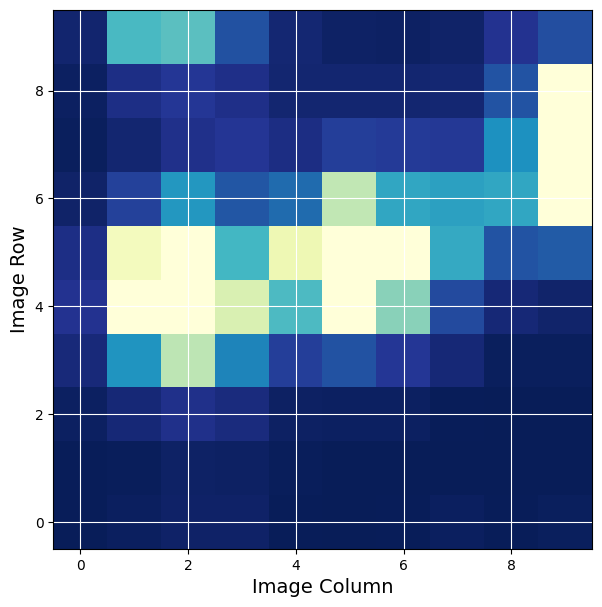

In [9]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage,xlabel='Image Column',ylabel='Image Row')

### Exercise 1: 

Describe the image that you see. Why are there multiple bright regions?

In [10]:
# Write your answer for Exercise 1 here


### Adding Gaia identifiers
Luckily, there is another mission called Gaia that is identifying the positions of all the stars in the sky. Let's plot what Gaia knows about this part of the sky on top of the image. To do that, we use a set of functions from Catalogs to access that catalog of data.

See the [Catalog Queries documentation](https://astroquery.readthedocs.io/en/latest/mast/mast_catalog.html) to find a full list of catalogs it can access. We're interested in the most recent Gaia catalog for this region. The TESS pixels are about 21 arcseconds wide, so our 10x10 TPF above is about 3.5 arcminutes wide; let's search for all Gaia sources within 2 arcminutes of our coordinate.

In [11]:
radSearch = 2/60 #radius in degrees
coordstring=str(ra1)+' '+str(dec1)

In [12]:
catalog_Gaia = Catalogs.query_object(coordstring, radius = radSearch, catalog = "Gaia")
catalog_Gaia

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance
str19,str28,str19,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,int64,int64,float64,int64,int64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64
1635721458409799680,Gaia DR2 2309225008197193856,2309225008197193856,987496898,2015.5,1.5082085216589867,0.01905251129927883,-36.90425177509987,0.02284001254711522,0.23366663200476057,0.02929834511782193,7.975421,9.14749123112842,0.036060909466475534,-14.574695793126974,0.050239371608376895,-0.0136014549,0.3581424,0.32358098,-0.05541873,-0.4409069,0.244410947,0.6452836,-0.169034362,-0.5563108,0.276266515,208,0,208,0,1.03447258,223.853271,0.0,0.0,31,True,99.5295639,1.6584442940114845,0.0046535940437352616,0.09164294,24,11,0.0606832467,0,24,False,208,76788.5339221387,944.9209905911819,81.2645,13.4751244,23,45785.16657205643,2106.2080700366637,21.7381973,13.6995764,22,47458.77367601469,1452.953057495976,32.6636658,13.0711288,1.21429515,0,0.628447533,0.224452019,0.4039955,nan,nan,0,nan,nan,nan,VARIABLE,344.5867360014971,-76.30216501436362,344.6422769199361,-34.00748730014099,100001,6798.0,6409.0,7031.0,1.535,1.3619,1.698,0.771,0.6774,0.8561,--,nan,nan,nan,nan,nan,nan,0.00012796238079567016
1635721458409799680,Gaia DR2 2309225008197194368,2309225008197194368,1415080713,2015.5,1.4993813373496883,0.0557408004684238,-36.912908844657004,0.05537160705992224,2.156711232369907,0.07226427643153532,29.8447781,18.18512274960824,0.10467352891059661,7.1604339697071895,0.1191504546190303,0.0481291451,0.349563241,0.354137629,-0.0103530241,-0.227913618,0.127697,0.481755584,-0.0601991564,-0.3225874,0.188399881,221,0,219,2,2.13329172,260.476624,0.18952167050518703,1.5624444360467842,31,True,4.084618,1.401697243359165,0.013088199076843145,0.08827993,25,12,0.119915351,0,25,False,219,4435.857955346408,3.2823499107173064,1351.42749,16.57092,21,1299.4342172566226,8.5

Scroll to the right; the catalog contains a LOT of information about these targets! We also see that 10 targets were returned, which is certainly more than we see in the image; some could be quite dim. Let's visualize the GAIA catalog sources on our targets. To do this, we'll now want our image to be displayed in terms of the World Coordinate System from the header. 

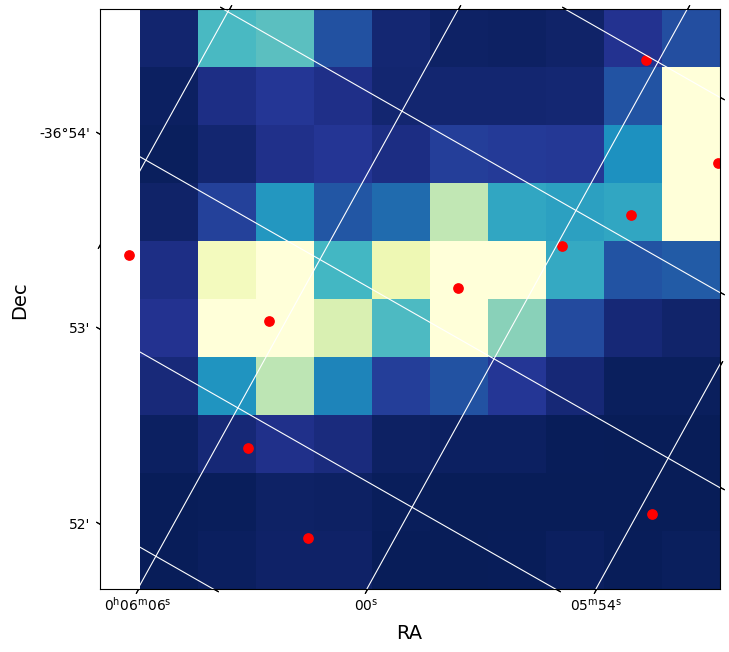

In [13]:
wcs = WCS(hdu1[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage,xlabel='RA',ylabel='Dec')

for i in range(len(catalog_Gaia)):
    starloc = wcs.all_world2pix([[catalog_Gaia['ra'][i],catalog_Gaia['dec'][i]]],0) 
    plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

We might like to narrow down our list by those stars that are the brightest in the TESS field of view. Let's now examine the TESS Input Catalog (TIC), which will include TESS magnitudes.

In [17]:
catalog_TIC = Catalogs.query_object(coordstring, radius = radSearch, catalog = "TIC")
catalog_TIC

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
str9,float64,float64,float64,float64,float64,str4,str7,str8,str1,str1,str10,str16,str1,str19,str19,str8,str1,str7,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str1,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,int64,str1,str5,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,float64
120488286,1.50815926825826,-36.9041890229087,9.14749,-14.5747,13.1434,STAR,tmgaia2,20190415,--,--,266-000113,00060194-3654151,--,J000601.96-365415.2,2309225008197193856,17445038,--,tmgaia2,0.0360609,0.0502394,gaia2,0.233667,0.0292983,gaia2,344.587051005379,-76.3021811550375,344.642259053118,-34.007412947138,13.811,0.301,13.495,0.206,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.54,0.025,12.276,0.025,12.203,0.025,AAA-222-111-000-0-0,nan,12.256,0.023,12.255,0.023,11.988,0.209,8.755,nan,13.4751,0.013361,0.0146,rered,gaia2,6452.0,241.0,3.15894,nan,nan,nan,4.99115,nan,1.31,nan,0.0105358,nan,DWARF,38.89323,nan,3579.76,367.87,0.00827775,0.0,--,nan,--,--,nan,1.49012e-10,-1.49012e-10,schlegel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,333.43,402.31,bj2018,nan,nan,dered,13.6996,0.049981,13.0711,0.03325,1,--,ucac4,apassdr9,--,0.589545515152915,0.77904558304867,1.50820852165899,-36.9042517750999,0.0190525112992788,0.0228400125471152,1,0,0.2636591313713208
120488285,1.49928341095074,-36.9129396742459,18.1851,7.16043,15.5561,STAR,tmgaia2,20190415,--,--,266-000110,00055982-3654466,--,J000559.84-365446.4,2309225008197194368,--,--,tmgaia2,0.104674,0.11915,gaia2,2.15671,0.0722643,gaia2,344.579885521841,-76.2910428796093,344.629682963477,-34.0116866453085,18.453,0.185,16.719,1.133,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,14.296,0.029,13.633,0.028,13.461,0.04,AAA-222-111-000-0-0,nan,13.369,0.024,13.363,0.028,12.547,nan,9.258,nan,16.5709,0.000803,0.00776896,cdwrf,cdwrf,3775.0,157.0,4.66553,0.015584,nan,nan,0.583121,0.0224282,0.574094,0.02357,2.89539,0.215811,DWARF,0.06221282,0.0152181974,458.043,15.292,0.008208,nan,32,0.199044615,--,--,8.290445e-05,nan,nan,schlegel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,bj2018,nan,nan,cdwrf,17.567,0.007115,15.5722,0.003047,1,--,ucac4,bpbj,cooldwarfs_v8,1.71133154754522,1.84765489079898,1.49938133734969,-36.912908844657,0.0557408004684238,0.0553716070599222,1,0,40.48303926970706
120488284,1.49369542262342,-36.9189252884794,12.9466,-6.25854,16.2054,STAR,tmgaia2,20190415,--,--,--,00055847-3655081,--,J000558.49-365508.1,2309224973837456128,--,--,tmgaia2,0.132041,0.15627,gaia2,1.35709,0.0949964,gaia2,344.573890410558,-76.2837101993064,344.6214897046

We also found 10 sources, and because Gaia is listed as as source for all 10, it's likely these are all the same sources (though you can confirm this for yourself)! Gaia's catalog was used to create the [TESS Input Catalog](https://tess.mit.edu/science/tess-input-catalogue/), so this is not surprising.

In [18]:
# Create a list of nearby bright stars (tess magnitude less than 16) from the rest of the data for later.
bright = catalog_TIC['Tmag'] < 16 
print(bright)

[ True  True False  True False  True False False False False]


Okay so there are lots of stars in this area of the sky. Which ones are the ones we care about? Let's do the same plot with this subset of the catalog that are bright.

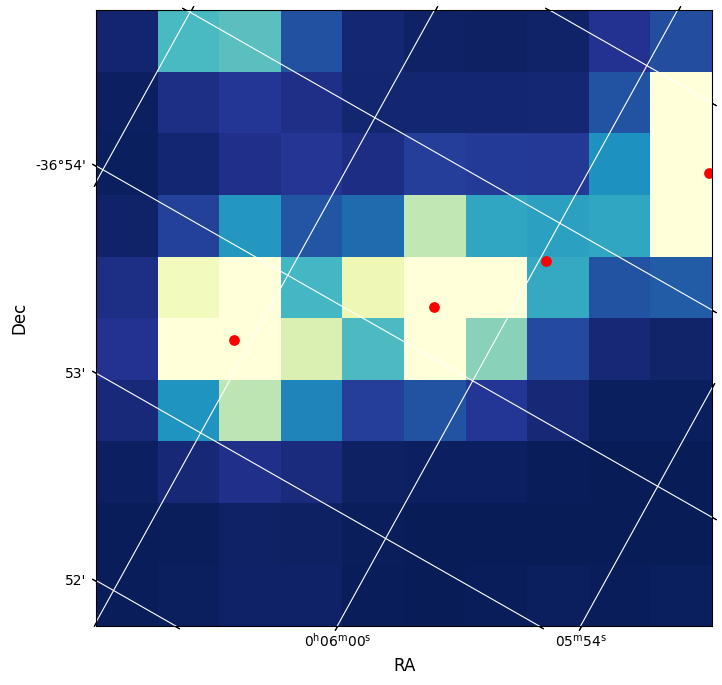

In [19]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)

TICbright=catalog_TIC[bright]
for i in range(len(TICbright)):
    starloc = wcs.all_world2pix([[TICbright['ra'][i],TICbright['dec'][i]]],0) 
    plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

### Exercise 2:
What is the Gaia name for the star on the left? What is the Gaia name of the star closest to the middle?
How about the TIC ID for the star closet to the middle?

In [20]:
# Write your code for Exercise 2 here
# The parallax angle is from the Gaia data, so let's examine that.
TICbright['ra','dec','GAIA','ID']
# There are many ways to figure out which is which.
# One method is to notice from the figure above that the star on the left 
# has the least negative Declination and the most positive RA.
# Therefore it is GAIA 2309230918072192512
# The star closet to the middle has the next most negative Declination and next most positive RA.
# Therefore it is GAIA 2309225008197193856, TIC 120488286
# Additionally, we could notice that the last column of the two catalog tables 
# tells us the distance from the search from coordinate and the tables
# are automatically ordered by lowest to largest distance;
# so the stars we were asked about should be the third and first 
# in the default table order, respectively.

ra,dec,GAIA,ID
float64,float64,str19,str9
1.50815926825826,-36.9041890229087,2309225008197193856,120488286
1.49928341095074,-36.9129396742459,2309225008197194368,120488285
1.526843917294,-36.8923236406745,2309230918072192512,120488287
1.48747585028645,-36.9275920019391,2309224973837456512,120461434


## Using lightkurve to save a lightcurve of one target star
Now that we know what the two stars are, how do we know which one has the interesting variability?

Luckily, someone has also made a tool to do this, it's called lightkurve (with a k), and it will allow us to look at how the light from each star changes over time by turning the brightness of each of these pixels into a timeseries (or light curve). 

We'll search by the TIC number you should have found in Exercise 2.

In [21]:
name='TIC'+str(TICbright['ID'][0])

In [22]:
search_result=lk.search_tesscut(name, sector=2)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESScut,1426,TIC120488286,0.0


We're going to use a slightly different size of cutout ("target pixel file", or tpf) here so we can see more stars.

In [23]:
tpf = search_result.download(cutout_size=15)

This package also gives us a very handy 'interact' function that allows us to click on a pixel, and see what its raw light curve looks like.

In [24]:
tpf.interact()

By clicking on the pixel data and selecting different masks, can you tell which star is the weirdly variable one (particular to one star), and which ones are dominated by the detector systematics (similar for every star)? (Shift/Control/Command should allow you to select and deselect individual pixels.) Notice that one of the systematic effects is that every pixel gets brighter at certain times - we'll see how this affects our light curve later!

### Exercise 3:

How many different stars are included in the first light curve you are shown? Which of those stars has the unique variability that drew the attention of your colleague? 

In [22]:
# Write your answer for Exercise 3 here
# By default, the aperture mask (shown in white-outlined pixels on the right hand side)
# appears to capture at least 3 bright stars. From the GAIA catalog data we first plotted,
# there may also be at least three other dim stars captured in the aperture.
# It is the one in the middle of the three that is the one with the unique variability.
# (The two periods of dimness followed by a rise seem to be systematic to the instrument, 
# because they appear in every pixel.)

## Using lightkurve to visualize and calculate stellar variability

Once you have selected only the star that is weirdly variable, use the 'Save Lightcurve' button on the bottom left to save a copy of that lightcurve. (Mine was named 'TESS_TIC120488286_custom-lc.fits') For our purposes, just choose the one pixel that shows the variability. We're interested in using this light curve to determine the period of the variability; if we were interested in the absolute flux values, we'd also want to do background subtraction to remove sky brightness and instrumental effects. We'd likely also need to remove the influence of the nearby stars we identified from the Gaia catalog.  

Now read in that lightcurve, and plot it. (lightkurve also has handly functions for this)

In [20]:
tesslc = lk.io.read('TESS_TIC120488286_custom-lc.fits')

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

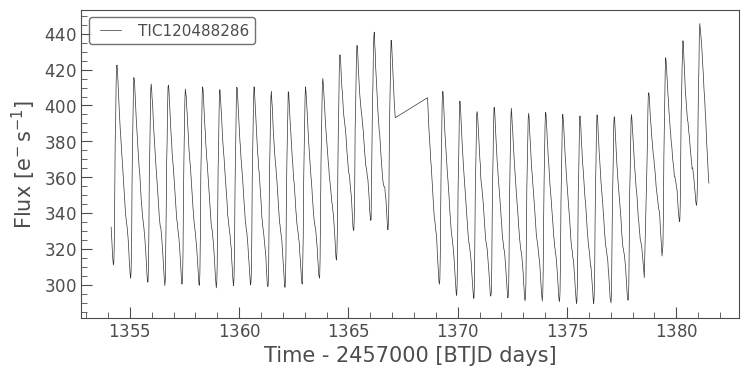

In [22]:
tesslc.plot()

When examining the variability of the star itself, always be careful to not confuse instrumental effects for astrophysical phenomena. In our case, remember that this light curve was derived by us using one pixel from a Full-Frame Image (FFI), with no background subtraction. There is a notable upstick (or "hockey-stick" pattern) that appears twice during this sector; once just before a "break" in the observations (at about 1367 on the horizontal axis), and again before the end of the sector. Because these two effects correspond in time to the end of observing periods, we can be confident that they are instrumental effects. 

### Exercise 4
Describe the shape of the variability of this star in words. Is it symmetric? What is the approximate period?

In [25]:
# Write your answer for Exercise 4 here
# It doesn't look symmetric; the flux rises quickly but drops more slowly. 
# Based on the tick marks, the period appears to be a bit less than a day.
# There seem to be about 6 oscillations per 5 days, so perhaps the period is about 0.8 days.

We can also use a variation of the Fourier Transform (called a Lomb-Scargle Periodogram) to identify the strongest frequency of variation exactly. Luckily, lightkurve also has a function for that.

In [26]:
pgrm=tesslc.to_periodogram()

Show the periodogram:

(0.0, 10.0)

<Figure size 700x700 with 0 Axes>

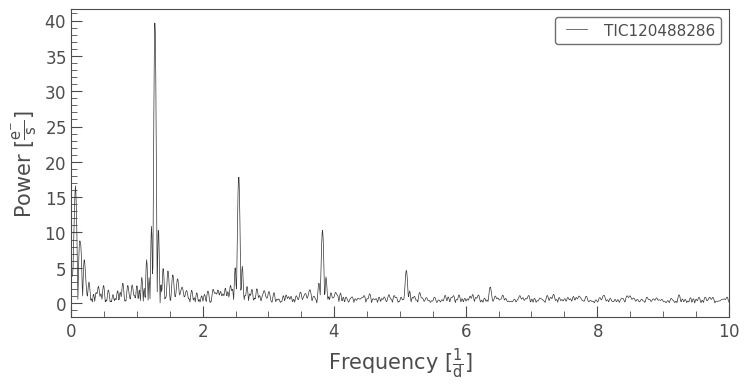

In [27]:
fig = plt.figure(figsize=(7, 7))
pgrm.plot()
plt.xlim([0,10])


In this case, the highest peak represents the actual period of variability, and the other peaks are located at *harmonics* of that frequency (2 x frequency, 3 x frequency, 4 x frequency and so on)

Lightkurve also has a function that will allow you to identify the period of the highest peak

In [28]:
period = pgrm.period_at_max_power
print(period)

0.7860462791530743 d


Now that we have the period, let's check that it looks right. To do that, we fold the data so that each period is plotted on top of the next period. If we really have the right period, all of the peaks will line up. 

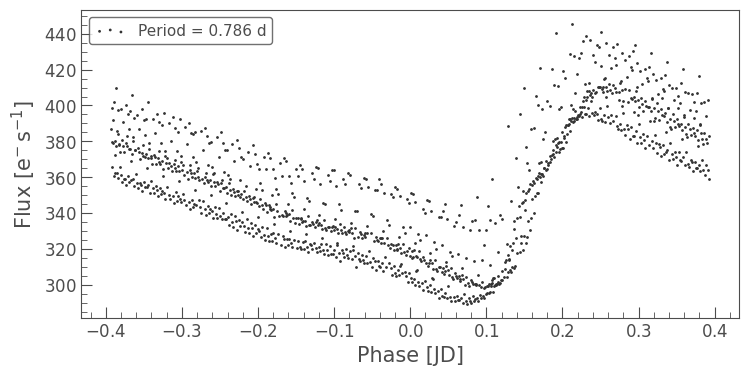

In [29]:
tesslc.fold(period).scatter(label=f'Period = {period.value:.3f} d');

The peaks and troughs line up in time values, but not in flux values! Remember the "hockey stick" pattern that we saw in the light curve? The flux values were higher closer to the end of observing periods; this is an effect that could be reduced with proper background subtraction. 

What if the period were off by 1%. What would that plot look like?

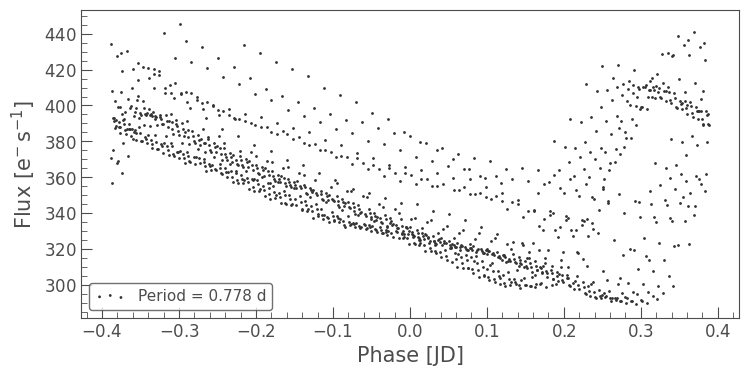

In [30]:
period2=period*.99
tesslc.fold(period2).scatter(label=f'Period = {period2.value:.3f} d');

### Exercise 5
What if the period were off by 1% in the other direction (period=1.01 x period we found) what would that plot look like?

In [31]:
# Write your answer for Exercise 5 here


### Exercise 6
Write an short email with the update you would give your colleague at this point, summarizing your results thus far. Include at least 2 concerns you still have about the data and/or results, and how someone could address them.

In [32]:
### Write your answer for Exercise 6 here


 ## Curate a set of stars by examining their light curves

Luckily you have a research assistant working with you this semester. You tell them to look through more data to see if they can find stars with similar variability. They bring you 14 options, listed below in the variable ``ticlist``. Your first task is to determine which of these 13 stars are in the same category as the first star you studied.

In [33]:
ticlist=['TIC270621410', 'TIC8999323', 'TIC439399635', 
         'TIC261745002', 'TIC279737991', 'TIC234507163',
         'TIC293526535', 'TIC325490196', 
         'TIC182729973','TIC144046456',
         'TIC120565065','TIC219316485', 'TIC149664951']

### Exercise 7
Write a loop that will do the following for each star in ``ticlist``:
- Search for and download a lightcurve using ``lightkurve``. For now, if multiple lightcurves are returned from ``search_lightcurve``, just use the first one.
- Compute the periodogram and plot the folded light curve.
- Append the period at maximum power to the array named ``periods``, defined below.

Finally, review the output to determine which of the 14 stars have qualitiatively similar light curves to the first one you studied.

Note that at the time of the writing of this tutorial, some of the lightcurves you download will be normalized by default, and some will not. This doesn't affect your ability to calculate the period and assess the shape of the light curve.

0 0.6160844489938412
1 0.5537245588590467
2 0.6063268326833051
3 0.34852319084571537
4 0.4917614460361833
5 0.41419113165422866
6 0.550060517585562
7 0.5680185786704803
8 3.4791593857152634
9 139.1669003941695
10 0.18211839077183506
11 0.36788349475201926
12 0.16930312081522095
[0.6160844489938412, 0.5537245588590467, 0.6063268326833051, 0.34852319084571537, 0.4917614460361833, 0.41419113165422866, 0.550060517585562, 0.5680185786704803, 3.4791593857152634, 139.1669003941695, 0.18211839077183506, 0.36788349475201926, 0.16930312081522095]


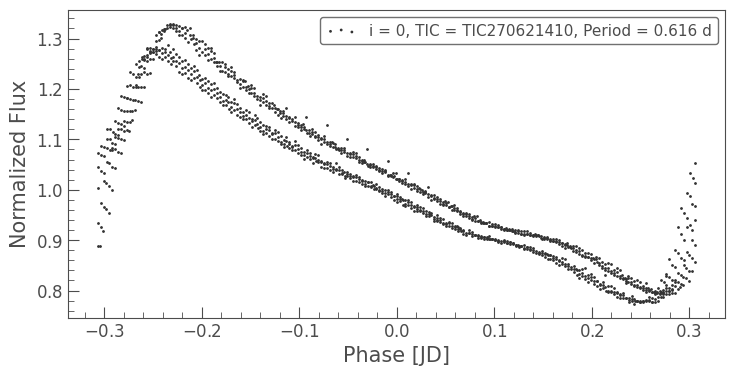

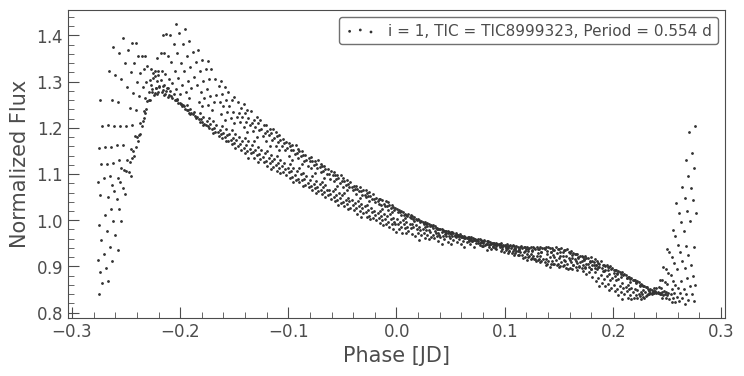

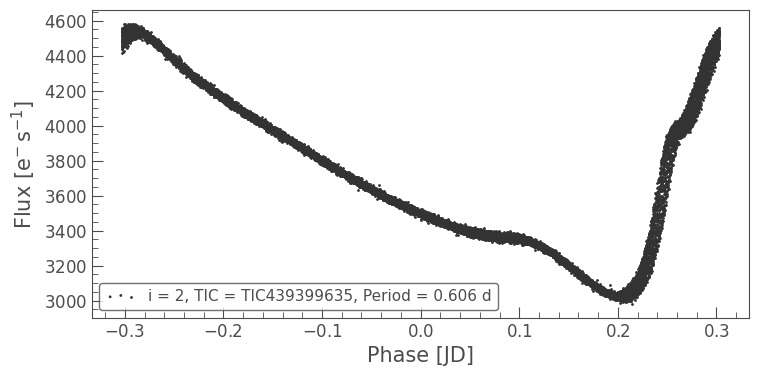

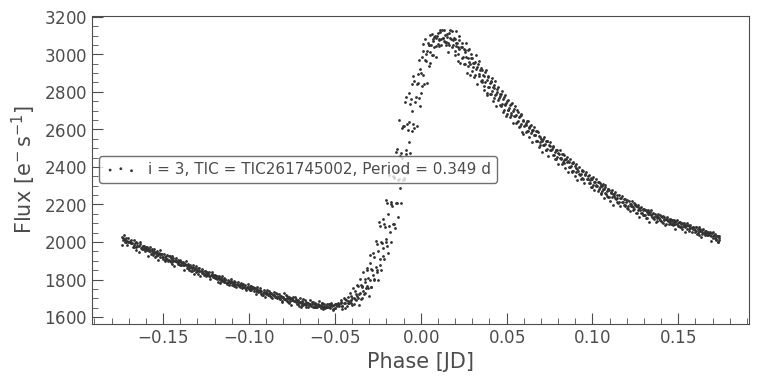

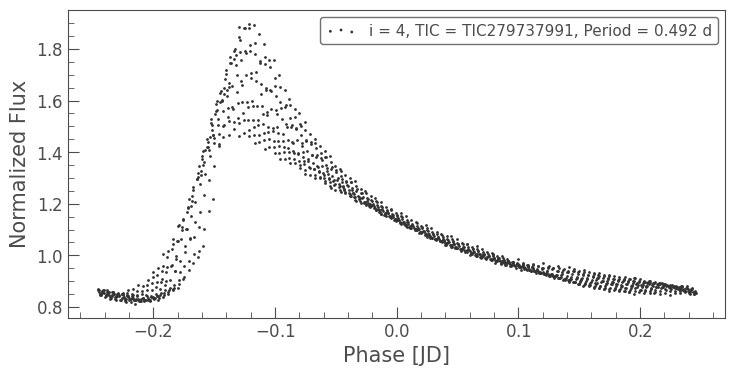

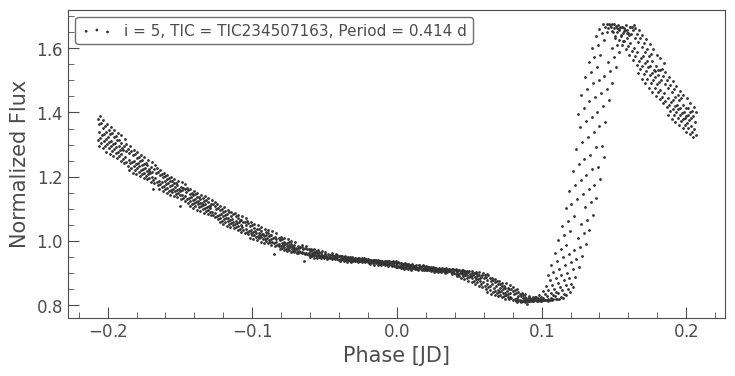

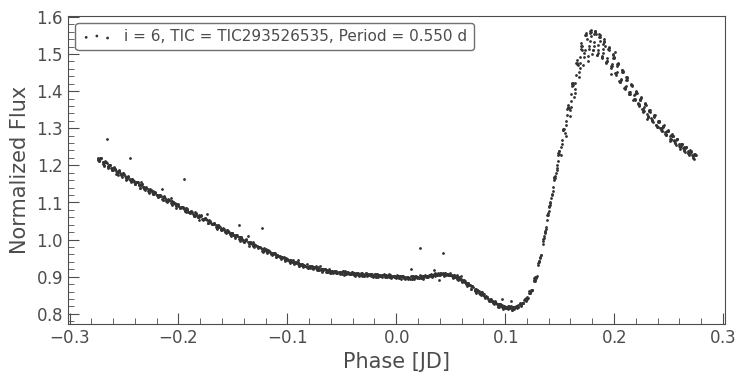

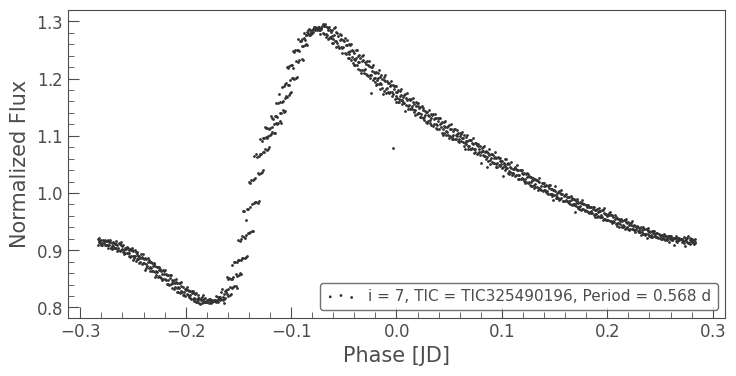

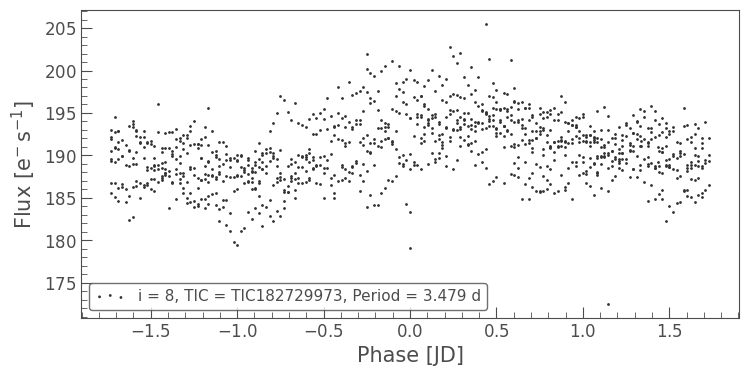

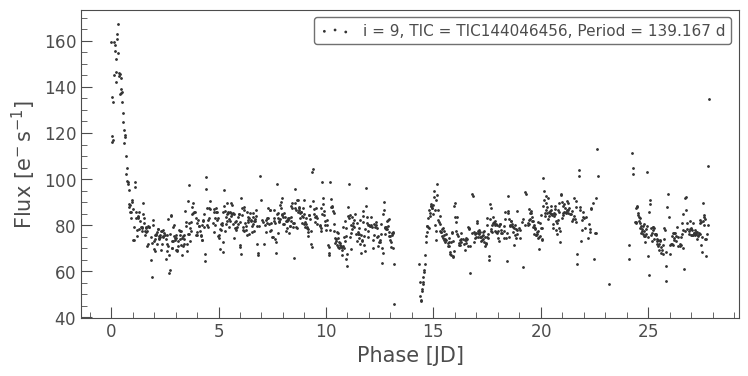

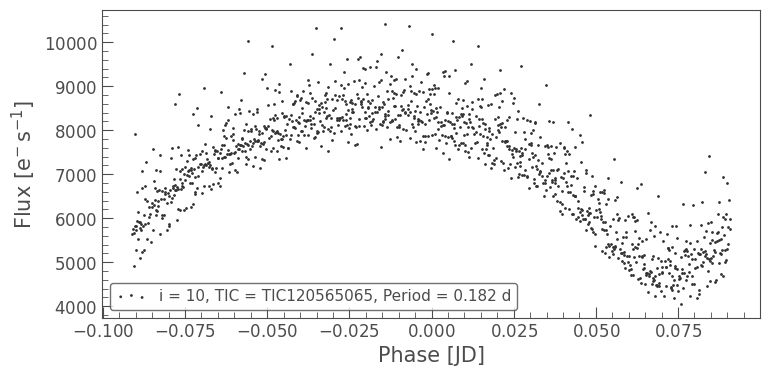

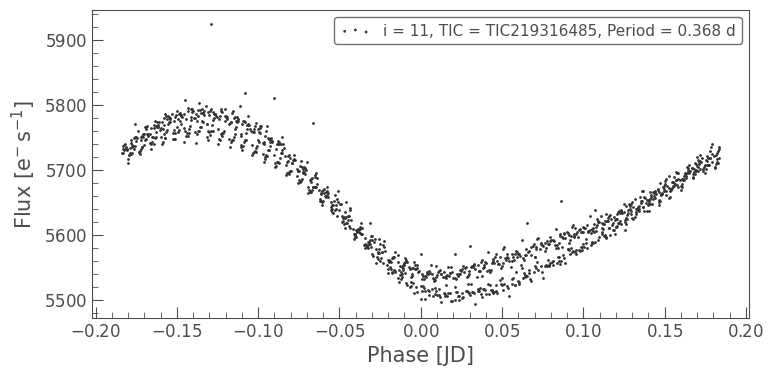

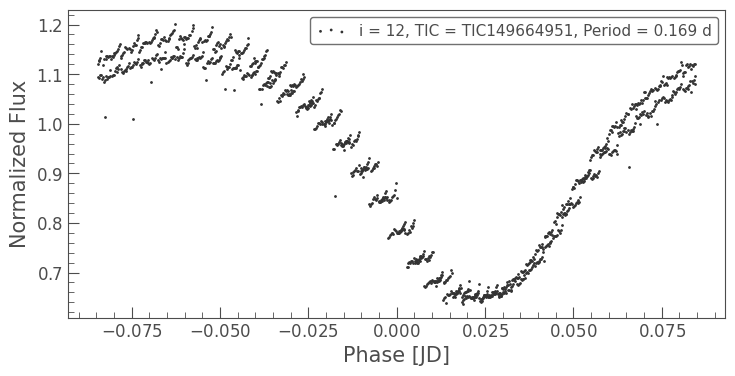

In [34]:
periods=[]
### Write your code for Exercise 7 here
for i in range(len(ticlist)):
    obs=lk.search_lightcurve(ticlist[i])
    tesslc=obs[0].download()
    #tesslc.plot()
    pgrm=tesslc.to_periodogram()
    #pgrm.plot()
    p=pgrm.period_at_max_power
    tesslc.fold(p).scatter(label='i = '+str(i)+', TIC = '+ticlist[i]+f', Period = {p.value:.3f} d');
    print(i,(p.value))
    periods.append(p.value)
print(periods)
# The first 8 in the list appear to be qualitiatively similar to our first star, 
# because they have periods just under a day and are characterized by a 
# steep rise and a slow decay in flux. Don't be mislead by where the rise happens 
# in the folded light curve; this is an arbitrary choice on where to count phase = 0. 
# The next two seem inconclusive; it is possible we could try to clean up the data
# or use another sector's data to create a better periodogram.
# The final three have periods that are around the right order of magnitude, though a bit
# smaller. However, their shape is noticeably different; the rise and fall of the 
# flux are more symmetric, almost sinusoidal in shape. This is likely a different phenomenon, 
# such as stellar rotation.

### Query the Gaia catalog for complementary data

As we saw above, the Gaia catalog and TESS Input Catalog (TIC) can provide additional information about these stars. From Exercise 7, you should have determined that the first eight stars in the list appear to be similar. What do the first eight stars in our list have in common; why are they different than the other stars? First, we'll query the Gaia catalog for each star, one at a time, and stack our resulting tables so that each row corresponds to one of the stars in our list.

In [35]:
# Being slow, commented out for now.
#for i in range(len(ticlist)):
#    result = Catalogs.query_object(ticlist[i],radius=1.0/3600.0,catalog="Gaia")
#    if i==0:
#        catalog_Gaia2=result
#    elif len(result)>0:
#        catalog_Gaia2=vstack([catalog_Gaia2,result])
#    else: 
#        print('Index '+str(i)+' not added.')
#catalog_Gaia2

In [46]:
# Temporary, Catalogs being slow
#catalog_Gaia2.write('catalog_Gaia2.dat', format='ascii', overwrite=False)
catalog_Gaia2=Table.read('catalog_Gaia2.dat',format='ascii')
catalog_Gaia2

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance
int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
1635721458409799680,Gaia DR2 2313783205448950784,2313783205448950784,23124726,2015.5,358.67365987618655,0.02842932273871129,-33.48135748170882,0.01919336987215386,0.4055421334175219,0.03261693885645263,12.4334822,20.42870589477595,0.05624473863638838,-19.249151794395885,0.03944826835466161,-0.04789078,0.379054546,0.187700436,-0.0620555766,-0.093423225,0.08455176,0.181731164,0.0563571267,-0.3498497,-0.0239271857,231,123,229,2,10.9240417,542.695862,0.0705639322371375,1.8258568986175039,31,True,89.45355,1.6476347561697458,0.006433784029618315,-0.057637848,26,12,0.0455393232,0,26,False,231,138317.14032451247,2116.913305434961,65.3390656,12.8361759,24,81930.85148426739,4629.992050384902,17.6956787,13.0677691,23,82206.00658237343,2896.764660938531,28.37856,12.4746609,1.18667042,0,0.5931082,0.231593132,0.361515045,nan,nan,0,nan,nan,nan,VARIABLE,2.0482677812472443,-76.22130046133316,344.12373849311393,-29.89842734192942,100001,6653.085,6570.46045,6802.0,nan,nan,nan,nan,nan,nan,200111,4.292886,4.10697651,4.401532,32.530117,27.7171211,37.3431129,0.007251287564276568
1635721458409799680,Gaia DR2 2385090584663565696,2385090584663565696,1475559472,2015.5,348.9580959512017,0.030590037933558963,-23.00365247956119,0.02918227432956867,0.461858043059929,0.037622273998425076,12.276186,25.27655598655174,0.06571897575166502,-16.961452292571817,0.061185366883999975,0.09171932,0.2833463,-0.0209503677,-0.07888287,-0.2692075,0.013566168,0.09291573,0.00149674492,-0.320635855,0.167967528,150,141,150,0,5.118623,249.841171,0.0,0.0,31,True,246.550018,1.6684754221030926,0.007759930219355821,0.00802268,17,10,0.04606426,0,17,False,150,170055.39015604847,2969.072358879655

From above, we can see that the Gaia catalog has a lot of columns. We'll be most interested in keeping:
- ``source-id``, the Gaia identifier number
- ``ra`` and ``dec``, coordinates in degrees
- ``parallax`` and ``parallax_error``, which is the parallax angle in milliarcseconds; this can be used to calculate a distance
- ``phot_variable_flag``, which tells us if this is a known variable star.
- NEED SOME FLUXES FOR CERTAIN BANDS?

Finally, these columns will help us place our stars on a HR diagram:
- ``teff_val``, ``teff_percentile_lower``, and ``teff_percentile_upper``, the effective temperature and lower/upper limits, in Kelvin
- ``lum_val``, ``lum_percentile_lower`` and ``lum_percentile_upper``, estimate of the luminosity and lower/upper limits in solar luminosities.

The TESS Input Catalog (TIC) also contains helpful information, and it includes a lot of this information from Gaia as well. 

Let's just examine the first 8 stars in our list; they showed the characteristic patterns of RR Lyrae stars. 

In [37]:
catalog_Gaia2=catalog_Gaia2[0:7]
periods=periods[0:7]
# periods=[[0.6160844489938412,0.5537245588590467,0.6063268326833051,0.34852319084571537,0.4917614460361833,0.41419113165422866,0.550060517585562]

## Correlate observable and intrinsic stellar properties

With all this information available to us, we can create plots of these properties. First, let's investigate where these stars appear on the [Hertzsprung-Russell (HR) diagram](https://openstax.org/books/astronomy-2e/pages/18-4-the-h-r-diagram) by plotting effective temperature vs. luminosity.

Text(0, 0.5, 'Solar Luminosities')

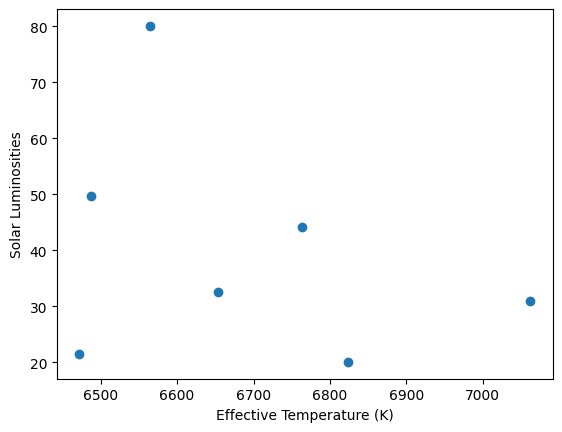

In [38]:
plt.plot(catalog_Gaia2['teff_val'],catalog_Gaia2['lum_val'],'o')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Solar Luminosities')

Remember, the temperature axis in an HR diagram is reversed! Also, the two axes should be use logarithmic scaling. Finally, let's also show the full scale of the HR diagram as it is typically shown.

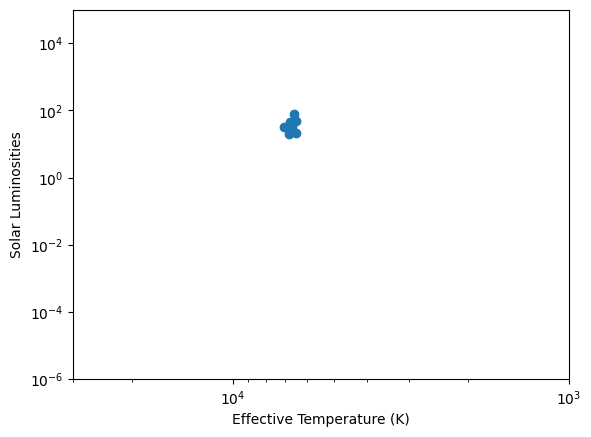

In [39]:
plt.plot(catalog_Gaia2['teff_val'],catalog_Gaia2['lum_val'],'o')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Solar Luminosities')
plt.xlim([30000,1000])
plt.ylim([1e-6,1e5])
plt.yscale('log')
plt.xscale('log')

By comparison to [typical HR diagrams](https://astronomy.swin.edu.au/cosmos/h/hertzsprung-russell+diagram), we can see that these stars occur in the RR Lyrae portion of the horizontal branch and the instability strip. They are less luminous than Cepheid variables. 

Are we able to see a clear period-luminosity relationship? 

Text(0, 0.5, 'Solar Luminosities')

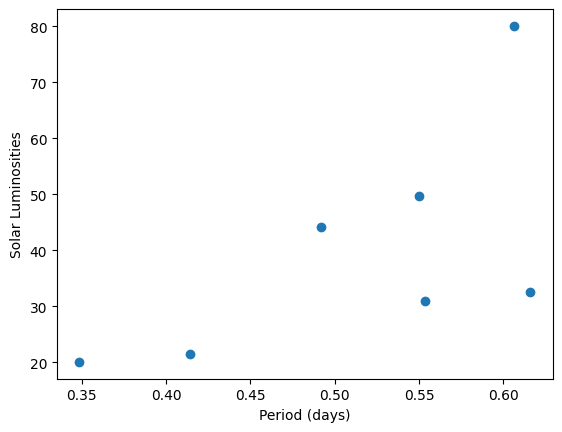

In [45]:
plt.plot(periods, catalog_Gaia2['lum_val'], 'o')
plt.xlabel('Period (days)')
plt.ylabel('Solar Luminosities')

While it's promising, we haven't seen a clear relationship just yet. A deeper dive into the literature may reveal a few reasons: for example, the RR Lyrae period-relationship may be most notable using the the longest-wavelength visible bands or infrared. It is also sensitive to the metallicity. You can investigate this more in the Additional Exercises below. 

## Additional Exercises

### Exercise 8: Period versus Luminosity with Error Bars

Recreate the period-luminosity plot, including the error bars on the total luminosity from the Gaia catalog. 

### Exercise 9: More Plots

Investigate additional plots you can make with the information we have. Consider, for example, the period on the horizontal axis and other quanitities such as effective temperature, parallax angle, or apparent magnitude in various bandpasses on the vertical axis. If possible, include error bars! 

### Reversing the relation

Another one of your colleagues has found another one of these stars- they have a period and an apparent magnitude, what is the distance (use the LMC)

Tess cut around the cvz- make them figure out its in the LMC

### Comparison to the Literature

Similar work was published in https://ui.adsabs.harvard.edu/abs/2022ApJS..258....8M/abstract

Read that paper and write a 1 paragraph summary of the methods, and a 1 paragraph summary of the results. 

List five similarities and five differences between what they did, and the analysis you did. 

## Additional Resources
- *The Glass Universe: How the Ladies of the Harvard Observatory Took the Measure of the Stars* (2016) by Dava Sobel, published by Penguin Books.

## Citations

If you use `astropy`, `lightkurve`, or `TESSCut` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* If you use TESSCut for your work, please cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)
* [Citing MAST missions](https://archive.stsci.edu/publishing/mission-acknowledgements)

## About this Notebook
For support, please contact the Archive HelpDesk at archive@stsci.edu.

**Author(s):** Jamie Tayar, Julia Kamenetzky  
**Keyword(s):** Tutorial, TIKEBook, TESSCut, variable stars, period-luminosity, Leavitt's Law  
**Last Updated:** Aug 2023  
**Next Review:** Feb 2024  
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 